In [1]:
!pip install -q tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 570kB/s 
     |████████████████████████████████| 501kB 56.8MB/s 
     |████████████████████████████████| 3.1MB 49.3MB/s 


In [0]:
import tensorflow as tf
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
tf.__version__

'2.0.0-beta1'

In [14]:
data_root = tf.keras.utils.get_file('Audio', 'https://os.unil.cloud.switch.ch/fma/fma_small.zip' , extract=True)

7679598592/7679594875 [==============================] - 285s 0us/step


In [0]:
!cp -r ~/.keras/datasets/fma_small /content

In [16]:
meta_data = tf.keras.utils.get_file('Meta' , 'https://os.unil.cloud.switch.ch/fma/fma_metadata.zip' , extract=True)

358416384/358412441 [==============================] - 14s 0us/step


In [0]:
!cp ~/.keras/datasets/fma_metadata/tracks.csv /content

In [0]:
genres_df = pd.read_csv('genres.csv')
genres_df.head()

,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5


In [18]:
tracks_df = pd.read_csv('tracks.csv' , index_col= 0 , header = [0,1])
keep_cols = [('set', 'split'),
('set', 'subset'),('track', 'genre_top')]

df_all = tracks_df[keep_cols]
df_all = df_all[df_all[('set', 'subset')] == 'small']

df_all['track_id'] = df_all.index
df_all.head()

set            track track_id
             split subset genre_top         
track_id                                    
2         training  small   Hip-Hop        2
5         training  small   Hip-Hop        5
10        training  small       Pop       10
140       training  small      Folk      140
141       training  small      Folk      141

In [19]:
df_all[('track' , 'genre_top')].unique()

array(['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International',
       'Electronic', 'Instrumental'], dtype=object)

In [0]:
def readAudioFile(trackid):
  track = '{:06d}'.format(trackid)
  return os.path.join('fma_small' , track[:3] , track + '.mp3')

In [0]:
def createSpectrogram(trackid):
  audio = readAudioFile(trackid)
  y, sr = librosa.load(audio , duration=2.97)
  spect = librosa.feature.melspectrogram(y=y, sr=sr)
  return spect

In [0]:
def plotSpectrogram(trackid):
  spectrogram = createSpectrogram(trackid)
  print(spectrogram.shape)
  librosa.display.specshow(spectrogram , y_axis='mel', x_axis='time')

In [0]:
def getTracks(audio_dir):
  tids = []
  for _, dirnames, files in os.walk(audio_dir):
      if dirnames == []:
          tids.extend(int(file[:-4]) for file in files)
  return tids

In [0]:
track_ids = getTracks('fma_small')

In [0]:
plotSpectrogram(3400)

In [20]:
df_train = df_all[df_all[('set', 'split')]=='training']
df_valid = df_all[df_all[('set', 'split')]=='validation']
df_test = df_all[df_all[('set', 'split')]=='test']

print(df_train.shape, df_valid.shape, df_test.shape)

(6400, 4) (800, 4) (800, 4)


In [0]:
def create_dataset(df):
  genres = []
  X_spect = np.empty((0 , 128 , 128))
  count = 0
  for index, row in df.iterrows():
    try:
        count += 1
        track_id = int(row['track_id'])
        genre = str(row[('track', 'genre_top')])
        spect = createSpectrogram(track_id)
        X_spect = np.append(X_spect, [spect], axis=0)
        genres.append(genre)
        if count % 100 == 0:
            print("Currently processing: ", count)
    except:
        print("Not processed : " , count)
        continue

  y_arr = np.array(genres)
  return X_spect, y_arr

In [35]:
X_valid , y_valid = create_dataset(df_valid)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800


In [0]:
X_train = create_dataset(df_train)

In [22]:
X_train.shape

(6394, 128, 128)

In [0]:
label_dict = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }

In [0]:
genres = []

In [0]:
for label in y_valid:
  genres.append(label_dict[label])

In [0]:
y_valid = np.array(genres)

In [0]:
labels = np.array(genres)

In [0]:
labels.shape

(6394,)

In [42]:
y_valid.shape

(800,)

In [0]:
y_valid = tf.keras.utils.to_categorical(y_valid , 8)

In [0]:
labels = tf.keras.utils.to_categorical(labels , 8)

In [0]:
labels[0]

array([0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [0]:
def getGenre(prob_vector):
  value = np.argmax(prob_vector)
  for genre , index in label_dict.items():
    if index == value:
      return genre

In [9]:
print(getGenre([0., 0., 0., 1., 0., 0., 0., 0.]))

Hip-Hop


In [0]:
labels = np.load('drive/My Drive/labels.npy')

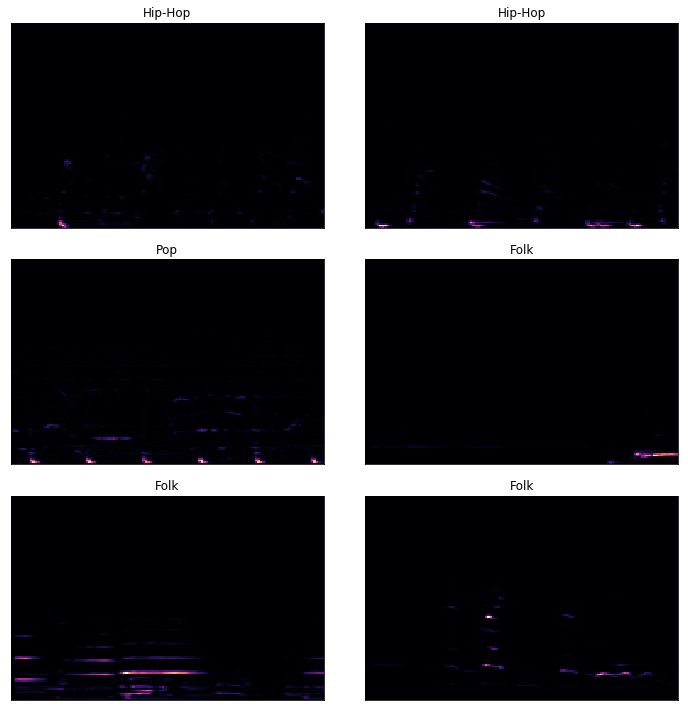

In [26]:
z = 0
fig , ax = plt.subplots(3 , 2 , figsize=(10 , 10))
fig.tight_layout()
for i in range(0,3):
  for j in range(0,2):
    plt.subplot(3 , 2 , z+1)
    librosa.display.specshow(X_train[z])
    plt.title(getGenre(labels[z]))
    z = z + 1
  

In [0]:
np.save('spectrograms.npy' , X_train)
np.save('labels.npy' , labels)

In [0]:
!cp labels.npy drive/My\ Drive/

In [0]:
X_valid = np.array([x.reshape((128 , 128 , 1)) for x in X_valid])

In [40]:
X_valid.shape

(800, 128, 128, 1)

In [0]:
model = tf.keras.Sequential()
input_shape = (128 , 128 , 1)

model.add(tf.keras.layers.Conv2D(24 , (5 , 5) , strides=(1 , 1) , input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D((4,2) , strides=(4 , 2)))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Conv2D(48 , (5 , 5) , padding='valid'))
model.add(tf.keras.layers.MaxPooling2D((4 , 2) , strides=(4 , 2)))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Conv2D(48 , (5 , 5) , padding='valid'))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Activation('softmax'))

In [82]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 124, 124, 24)      624       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 62, 24)        0         
_________________________________________________________________
activation_5 (Activation)    (None, 31, 62, 24)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 58, 48)        28848     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 29, 48)         0         
_________________________________________________________________
activation_6 (Activation)    (None, 6, 29, 48)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 25, 48)        

In [0]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True),
]

In [0]:
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

In [48]:
model.fit(
    x=X_train,
    y=labels,
    epochs=50,
    batch_size=128,
    validation_data=(X_valid , y_valid),
    callbacks=callbacks,
)

W0709 16:32:47.118226 140459465447296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6394 samples, validate on 800 samples
Epoch 1/50
6272/6394 [============================>.] - ETA: 1s - loss: 3.4842 - accuracy: 0.1440
Epoch 00001: val_loss improved from inf to 2.07237, saving model to model.h5
6394/6394 [==============================] - 86s 13ms/sample - loss: 3.4572 - accuracy: 0.1444 - val_loss: 2.0724 - val_accuracy: 0.1400
Epoch 2/50
6272/6394 [============================>.] - ETA: 1s - loss: 2.0815 - accuracy: 0.1617
Epoch 00002: val_loss improved from 2.07237 to 2.05376, saving model to model.h5
6394/6394 [==============================] - 84s 13ms/sample - loss: 2.0811 - accuracy: 0.1623 - val_loss: 2.0538 - val_accuracy: 0.1863
Epoch 3/50
6272/6394 [============================>.] - ETA: 1s - loss: 2.0559 - accuracy: 0.1819
Epoch 00003: val_loss improved from 2.05376 to 2.01450, saving model to model.h5
6394/6394 [==============================] - 84s 13ms/sample - loss: 2.0540 - accuracy: 0.1836 - val_loss: 2.0145 - val_accuracy: 0.2138
Epoch 4/5

In [0]:
  for index , row in df_test.iterrows():
    track_id = int(row['track_id'])
    gen1 = str(row[('track', 'genre_top')])
    spect1 = createSpectrogram(track_id)
    break

In [0]:
test = np.array(specter).reshape((128 , 128 , 1))

In [0]:
test1 = np.expand_dims(test , axis=0)

In [170]:
test1.shape

(1, 128, 128, 1)

In [0]:
res = model.predict(test2)

In [197]:
getGenre(res)

'Pop'

In [0]:
def getGenreFromValue(value):
  for i , j in label_dict.items():
    if j == value:
      return i
    

In [198]:
for i in range(0,8):
  print('{} : {}\n'.format(getGenreFromValue(i) , res[0][i]))

Electronic : 0.09282361716032028

Experimental : 0.04594282805919647

Folk : 0.08038511127233505

Hip-Hop : 0.051831576973199844

Instrumental : 0.02783791720867157

International : 0.10592349618673325

Pop : 0.3225657045841217

Rock : 0.2726898193359375



In [0]:
y, sr = librosa.load('Coldplay - Hymn For The Weekend (Official Video).mp3' , offset=120.0 , duration=2.97)
specter = librosa.feature.melspectrogram(y=y, sr=sr)

In [0]:
model.save('genre-model.h5')

In [0]:
model = tf.keras.models.load_model('genre-model.h5')

In [0]:
model.load_weights('model.h5')

In [178]:
model.outputs

[<tf.Tensor 'activation_4_2/Identity:0' shape=(None, 8) dtype=float32>]

In [0]:
tf.saved_model.save(model , "/tmp/genre/1/")

In [185]:
!saved_model_cli show --dir /tmp/genre/1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['conv2d_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 128, 128, 1)
      name: serving_default_conv2d_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['activation_4'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 8)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [186]:
loaded = tf.saved_model.load("/tmp/genre/1/")
print(list(loaded.signatures.keys())) 

['serving_default']


In [187]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'activation_4': TensorSpec(shape=(None, 8), dtype=tf.float32, name='activation_4')}


In [188]:
model.output_names[0]

'activation_4'

In [0]:
test2 = test1.astype('float32')

In [209]:
test2.shape

(1, 128, 128, 1)

In [0]:
labeling = infer(tf.constant(test2))[model.output_names[0]]

In [211]:
getGenre(labeling)

'Pop'

In [0]:
!nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=genre \
  --model_base_path="/tmp/genre" >server.log 2>&1

In [0]:
!pip install -q requests
import json
import numpy
import requests
data = json.dumps({"signature_name": "serving_default",
                   "instances": test2.tolist()})
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/genre:predict',
                              data=data, headers=headers)
predictions = numpy.array(json.loads(json_response.text)["predictions"])

In [0]:
import subprocess

In [0]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

In [216]:
!apt-get install tensorflow-model-server


Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package tensorflow-model-server


In [0]:
!cp -r /tmp /content/drive/My\ Drive/